In [1]:
import rosbag
import ros_numpy
import sensor_msgs
from o3d_util import visualize_multiple_pcd
import numpy as np
from matplotlib import pyplot as plt
from transforms import build_se3_transform, transform_numpy_pcd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
bag = rosbag.Bag('../calib/data/football_g.bag')
count = 0
zedmsg = None
velmsg = None
for topic, msg, t in bag.read_messages(topics=['/velodyne_points', '/zed/zed_node/left/image_rect_color']):
    count+=1
    print('#####')
    print(msg.header.stamp.secs)
    print(msg.header.stamp.nsecs)
    print(t)
    print(msg.header.frame_id)
    if msg.header.frame_id=='zed_left_camera_optical_frame':
        zedmsg = msg 
    if msg.header.frame_id=='velodyne':
        velmsg = msg
    
    if zedmsg is not None and velmsg is not None:
        break

#####
1672150211
90331403
1672150211259967650
zed_left_camera_optical_frame
#####
1672150211
290324403
1672150211369433518
zed_left_camera_optical_frame
#####
1672150211
570751667
1672150211575120693
velodyne


In [12]:
len(velmsg.data)

557920

In [13]:
len(zedmsg.data)

921600

In [14]:
velmsg.__class__ = sensor_msgs.msg.PointCloud2
velnp = ros_numpy.numpify(velmsg)

In [15]:
pc = []
for point in velnp:
    pc.append(list(point)[:3])
pc = np.array(pc)

In [16]:
visualize_multiple_pcd([pc])

In [17]:
np.array(list(velnp[0])[:3])

array([-8.78368  ,  2.6218677, -2.456193 ], dtype=float32)

In [18]:
zedmsg.__class__ = sensor_msgs.msg.Image
zednp = ros_numpy.numpify(zedmsg)
img = zednp[:, :, :3]


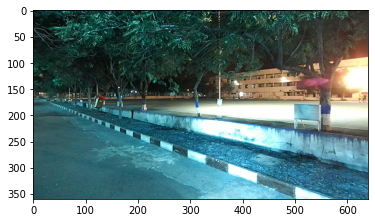

In [19]:
plt.imshow(img)
plt.show()

In [17]:
visualize_multiple_pcd([pc])

#  New Data

In [20]:
bag = rosbag.Bag('../calib/data/football_g.bag')
count = 0
zedmsg = None
zedmsg_img = None
velmsg = None
for topic, msg, t in bag.read_messages(topics=['/velodyne_points', '/zed/zed_node/left/image_rect_color', '/zed/zed_node/point_cloud/cloud_registered']):
    count+=1
    print('#####')
    print(t)
    print(msg.header.frame_id)
    if msg.header.frame_id=='zed_left_camera_frame':
        zedmsg = msg 
    if msg.header.frame_id=='velodyne':
        velmsg = msg
    if msg.header.frame_id=='zed_left_camera_optical_frame':
        zedmsg_img = msg
    
    if zedmsg is not None and velmsg is not None and zedmsg_img is not None:
        break

#####
1672150211259967650
zed_left_camera_optical_frame
#####
1672150211369433518
zed_left_camera_optical_frame
#####
1672150211498615509
zed_left_camera_frame
#####
1672150211575120693
velodyne


In [21]:
velmsg.__class__ = sensor_msgs.msg.PointCloud2
velnp = ros_numpy.numpify(velmsg) 
vpc = []
for point in velnp:
    vpc.append(list(point)[:3])
vpc = np.array(vpc)

In [22]:
zedmsg.__class__ = sensor_msgs.msg.PointCloud2
zednp = ros_numpy.numpify(zedmsg)
zpc = []
for row in zednp:
    for point in row:
        point = list(point)[:3]
        if not np.any(np.isnan(point)) and not np.any(np.isinf(point)):
            zpc.append(point)
zpc = np.array(zpc)

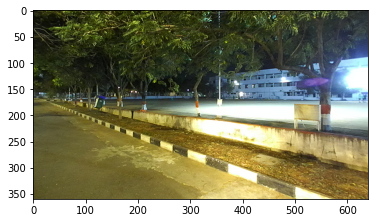

In [23]:
zedmsg_img.__class__ = sensor_msgs.msg.Image
zednp_img = ros_numpy.numpify(zedmsg_img)
img = zednp_img[:, :, [2,1,0]]

plt.imshow(img)

In [24]:
def velo_to_cam(pcd, P, T):
        out =  (P @ T @ pcd.T).T

        out[:, 0] = out[:, 0] / out[:, 2]
        out[:, 1] = out[:, 1] / out[:, 2]
        out[:, 2] = out[:, 2] / out[:, 2]

        return out

### Calib Dump

K = [336.3924560546875, 0.0, 307.7497863769531, 0.0, 336.3924560546875, 165.84719848632812, 0.0, 0.0, 1.0]


T_camo_c = build_se3_transform([0.13, -0.4, -0.8, 0, 0, 0])

T_camo_c = build_se3_transform([0.13, -0.35, -0.7, 0, 0, 0]) # Final as of Dec28 1:05PM

Sarat Filter:
pcd = pcd[pcd[:, 0]>2]
pcd = pcd[pcd[:, 0]<6]
pcd = pcd[pcd[:, 1]<2]
pcd = pcd[pcd[:, 1]>-1]
pcd = pcd[pcd[:, 2]<0.5]


In [25]:
# From rostopic echo /zed/zed_node/left/camera_info
K = [336.3924560546875, 0.0, 307.7497863769531, 0.0, 336.3924560546875, 165.84719848632812, 0.0, 0.0, 1.0]
K = np.array(K).reshape((3,3))
K = np.hstack([K, np.array([0,0,0]).reshape(3,1)])
K



array([[336.39245605,   0.        , 307.74978638,   0.        ],
       [  0.        , 336.39245605, 165.84719849,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

[[ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 1  0  0  0]
 [ 0  0  0  1]]


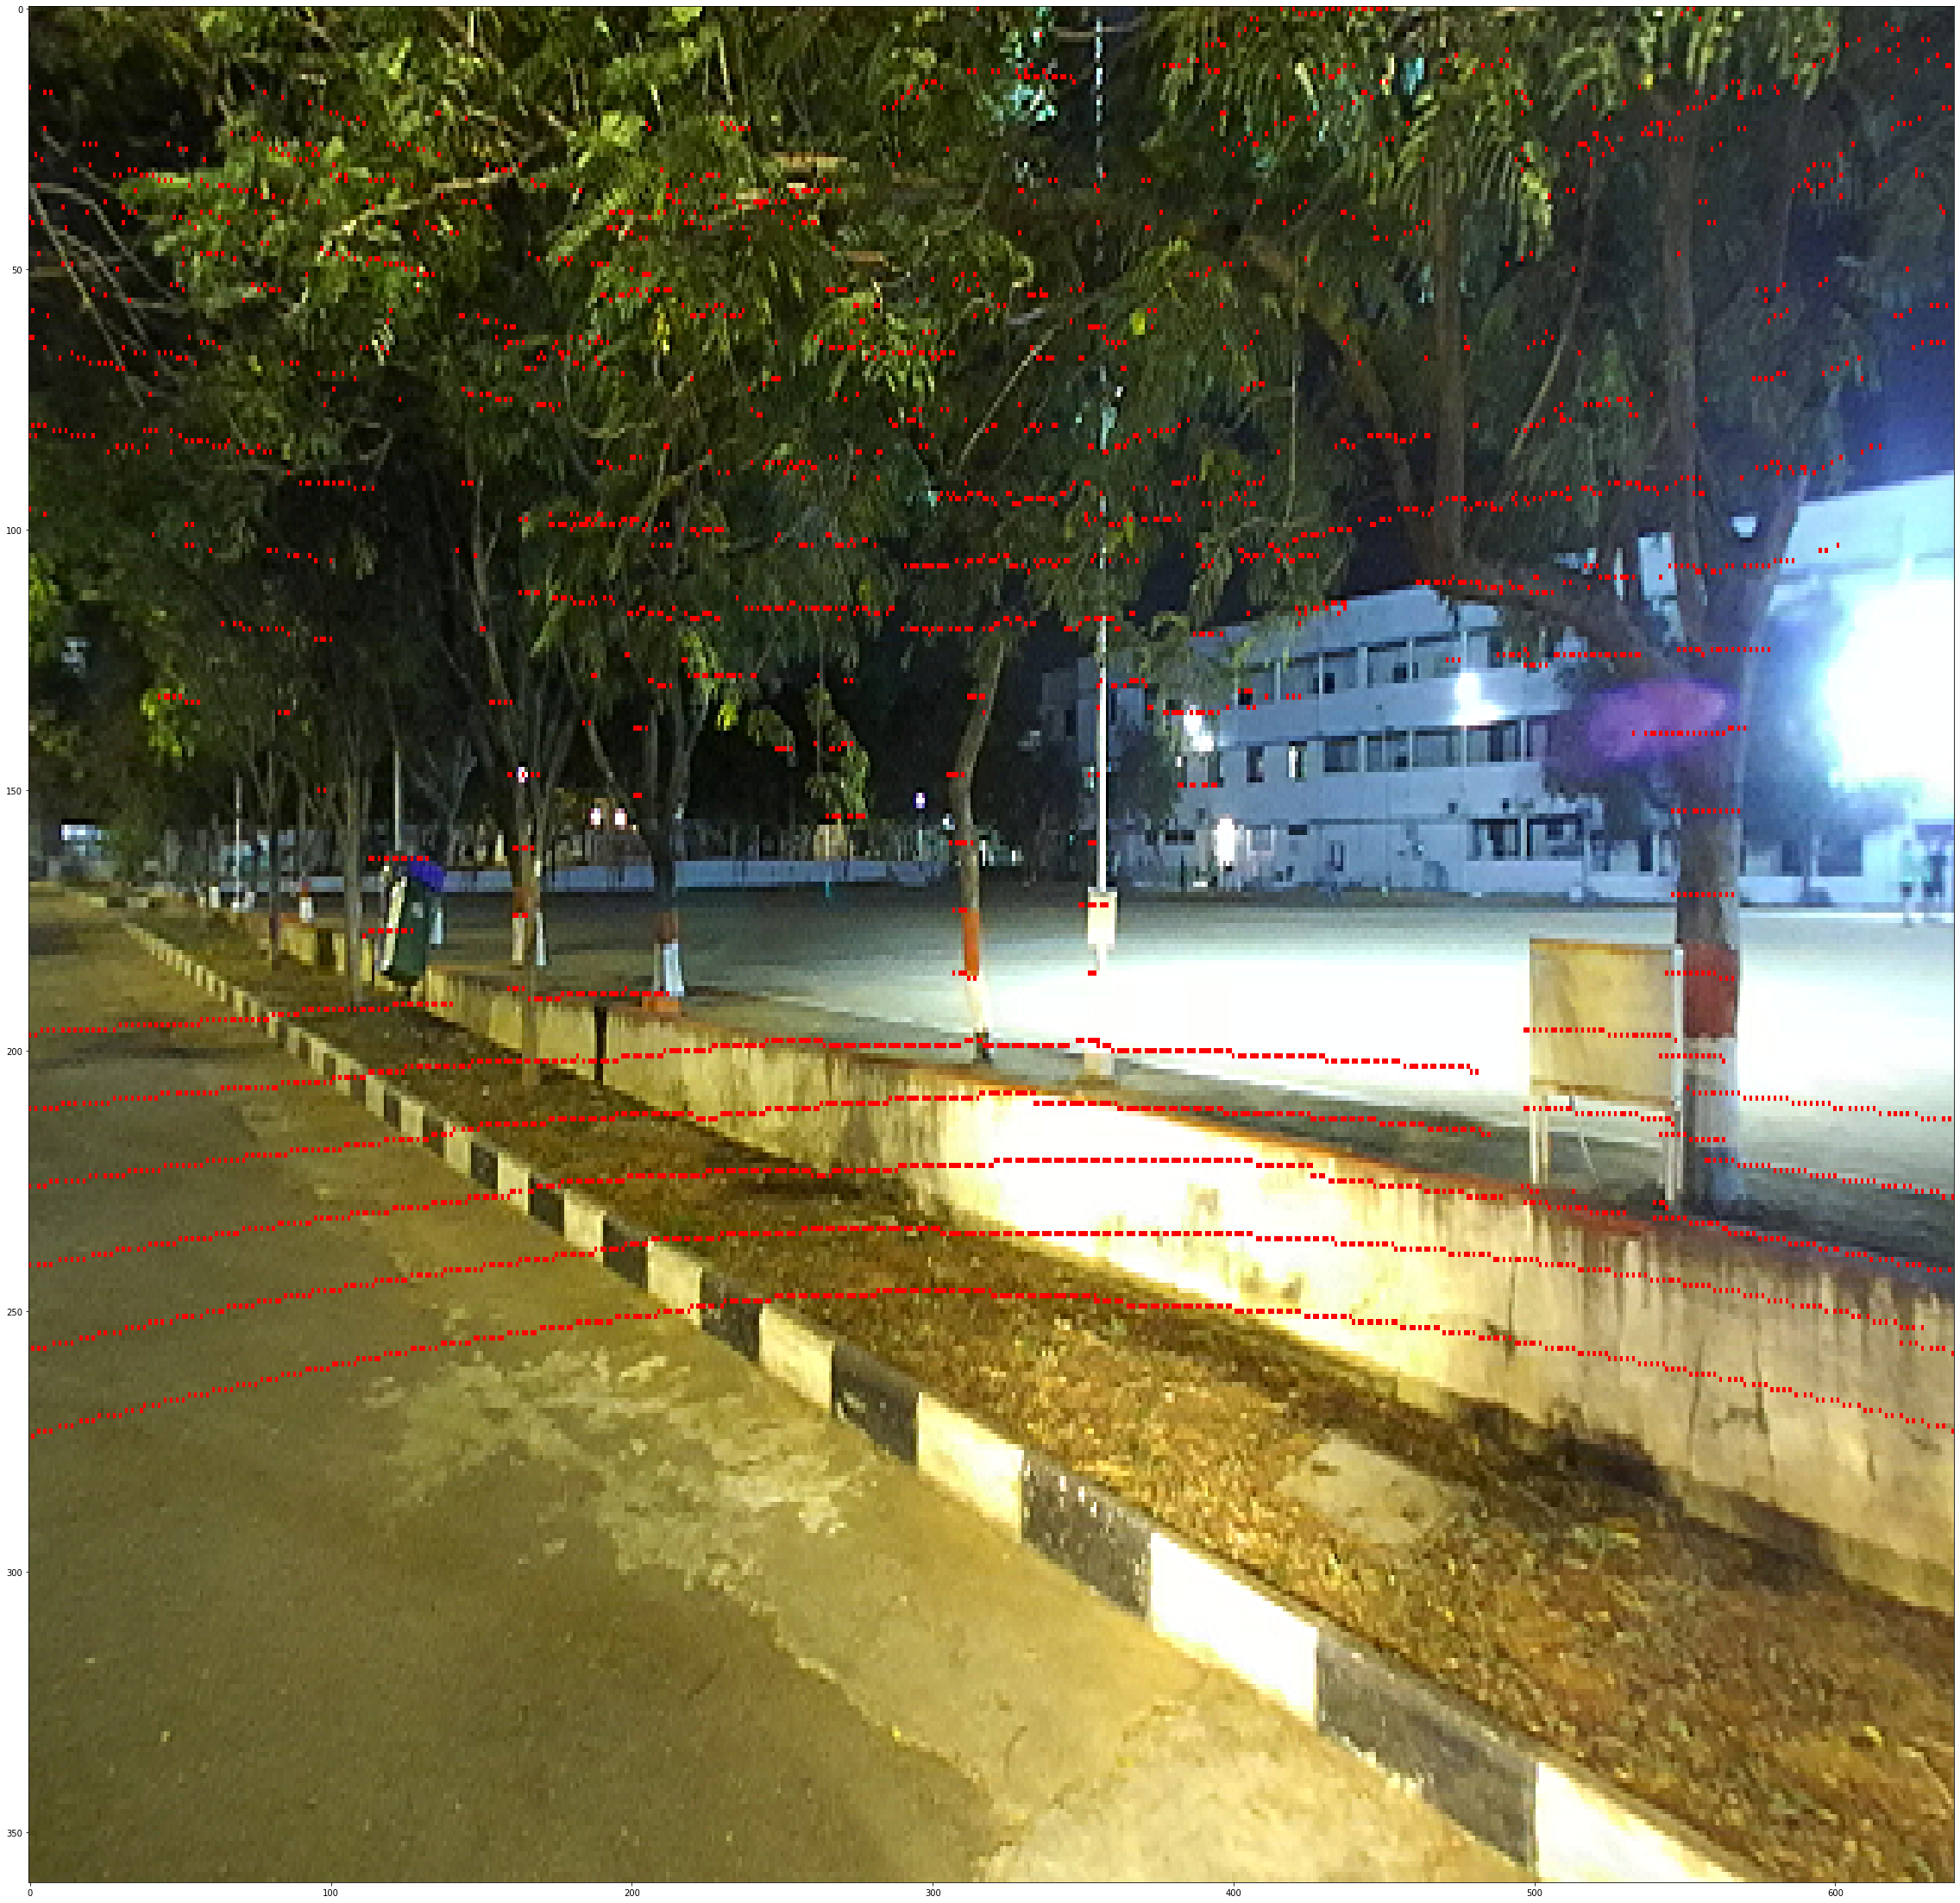

In [26]:
pcd =  np.hstack([vpc, np.ones((vpc.shape[0], 1))])
# pcd = pcd[pcd[:, 0]>3]
# pcd = pcd[pcd[:, 0]<15]
# pcd = pcd[pcd[:, 1]<3]
# pcd = pcd[pcd[:, 1]>-3]
# pcd = pcd[pcd[:, 2]>0]

# pcd = pcd[pcd[:, 0]>2]
pcd = pcd[pcd[:, 0]<15]
# pcd = pcd[pcd[:, 1]<2]
# pcd = pcd[pcd[:, 1]>-1]
# pcd = pcd[pcd[:, 2]<0.5]
visualize_multiple_pcd([pcd[:, :3]])


mask = np.ones(pcd.shape[0])
mask[np.where(pcd[:,0]<1)[0]] = 0

# T_camo_c = build_se3_transform([-0.8, 0, 0.7, 0, 0, 0])
T_camo_c = build_se3_transform([0.13, -0.35, -0.7, 0, 0, 0])
# T_camo_c = build_se3_transform([0, 0, 0, 0, 0, 0])
P = K @ T_camo_c

Tr = [0, -1,  0, 0, 
      0,  0, -1, 0, 
      1,  0,  0, 0]
Tr = np.array(Tr).reshape(3,4)
Tr_vel_camo = np.vstack([Tr, [0,0,0,1]])

# Tr_vel_camo = build_se3_transform([0,0,0,0,0,0])

print(Tr_vel_camo)

# # Projective Geometry
pts_cam = velo_to_cam(pcd, P, Tr_vel_camo)
pts_cam = np.array(pts_cam, dtype=np.int32)  # 0th column is img height (different from kitti)


# #  Filter pts_cam to get only the point in image limits
# # There should be a one liner to do this.
mask[np.where(pts_cam[:,0] >=img.shape[1])[0]] = 0
mask[np.where(pts_cam[:,0] <0)[0]] = 0
mask[np.where(pts_cam[:,1] >=img.shape[0])[0]] = 0
mask[np.where(pts_cam[:,1] <0)[0]] = 0

# mask_idx are indexes we are considering, where mask is 1
mask_idx = np.where([mask>0])[1]  # Somehow this returns a tuple of len 2

# Project lidar points on camera plane
img = zednp_img[:, :, [2,1,0]]

img[pts_cam[mask_idx, 1], pts_cam[mask_idx, 0], :] = (255, 0, 0)

fig, axes = plt.subplots(1, 1, figsize=(40,40))
axes.imshow(img, aspect='auto')


In [205]:
idx = 0  # img height
pts_cam[:, idx].min(), pts_cam[:, idx].max()

(-2225, 4661)

In [150]:
idx = 1 # img width
pts_cam[:, idx].min(), pts_cam[:, idx].max()

(172, 271)

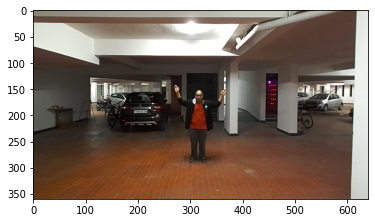

In [139]:
img = zednp_img[:, :, [2,1,0]]

plt.imshow(img)
plt.show()

In [135]:
(pcd[:, 2].max() - pcd[:, 2].min())

1.0631049126386642